In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.4.1
sys.version_info(major=3, minor=7, micro=10, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.19.5
pandas 1.1.5
sklearn 0.22.2.post1
tensorflow 2.4.1
tensorflow.keras 2.4.0


In [3]:
# 取出来的词表从1开始，要进行处理
vocab_size=10000
# <3的id都是特殊字符
index_from=3
# 用keras里面的imdb数据集
imdb=keras.datasets.imdb
# 下载数据集，分为训练集、测试集
# num_words是词频，这里拿词频排名前10000的；取值为None,是保留所有单词
(train_data,train_labels),(test_data,test_labels)=imdb.load_data(num_words=vocab_size,index_from=index_from)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [10]:
# 输出是数值列表，要通过imdb_word_index.json对应到电影名字

# 训练集的大小
print(train_data.shape)
print(train_labels.shape)
# 训练集的第一个样本（是向量）
print(train_data[0],train_labels[0])
# 多维的数组 numpy.ndarray
print(type(train_data))
print(type(train_labels))
# train_labels的值0(negative),1(positive)-二分类
print(np.unique(train_labels))


(25000,)
(25000,)
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32] 1
<class 'numpy.ndarray'>
<class 'numpy.nd

In [7]:
#样本长度变长，后面需要处理为等长
print(len(train_data[0]),len(train_data[1]),len(train_data[100]))

218 189 158


In [11]:
# 测试集的大小
print(test_data.shape)
print(test_labels.shape)

(25000,)
(25000,)


In [14]:
# 下载词表，就是imdb_word_index.json
# key是单词，value是索引
word_index=imdb.get_word_index()
print(len(word_index))
print(type(word_index))

88584
<class 'dict'>


In [20]:
# word-level
print(word_index.get("footwork"))

34707


In [17]:
# 取到的词表索引从1开始，id都偏移3
word_index={k:(v+3) for k,v in word_index.items()}
# 自定义索引0-3
word_index['<PAD>']=0 #填充字符
word_index['<START>']=1 #起始字符
word_index['<UNK>']=2 #找不到就返回UNK
word_index['<END>']=3 #结束字符

# 转成习惯的形式-索引是key,单词是value，就可以实现解码：把数字对应到一句单词组成的话
reverse_word_index=dict([(value,key) for key,value in word_index.items()])
print(type(reverse_word_index))
# 查看解码效果
print(reverse_word_index)


# 解码函数
def decode_review(text_ids):
  return " ".join([reverse_word_index.get(word_id,"<UNK>") for word_id in text_ids])

# 逐个对单词解码，得到一篇文本
decode_review(train_data[0])

<class 'dict'>
{34710: 'fawn', 52015: 'tsukino', 52016: 'nunnery', 16825: 'sonja', 63960: 'vani', 1417: 'woods', 16124: 'spiders', 2354: 'hanging', 2298: 'woody', 52017: 'trawling', 52018: "hold's", 11316: 'comically', 40839: 'localized', 30577: 'disobeying', 52019: "'royale", 40840: "harpo's", 52020: 'canet', 19322: 'aileen', 52021: 'acurately', 52022: "diplomat's", 25251: 'rickman', 6755: 'arranged', 52023: 'rumbustious', 52024: 'familiarness', 52025: "spider'", 68813: 'hahahah', 52026: "wood'", 40842: 'transvestism', 34711: "hangin'", 2347: 'bringing', 40843: 'seamier', 34712: 'wooded', 52027: 'bravora', 16826: 'grueling', 1645: 'wooden', 16827: 'wednesday', 52028: "'prix", 34713: 'altagracia', 52029: 'circuitry', 11594: 'crotch', 57775: 'busybody', 52030: "tart'n'tangy", 14138: 'burgade', 52032: 'thrace', 11047: "tom's", 52034: 'snuggles', 29123: 'francesco', 52036: 'complainers', 52134: 'templarios', 40844: '272', 52037: '273', 52139: 'zaniacs', 34715: '275', 27640: 'consenting', 

"<START> to was br who actress rate shouldn't historical she mother nicholson even synopsis <UNK> director be girl <UNK> with its who leads watch about documentary <UNK> <UNK> he i'd money <UNK> should <UNK> makes watch didn't <UNK> mind stupid at <UNK> makes arrived dancing in obviously all of entertaining <UNK> seems about br <UNK> such sea i to was <UNK> ladies pokemon example <UNK> was story do a br who actress all can is of immediately <UNK> was in flick in a br running it <UNK> <UNK> up start a <UNK> version <UNK> could <UNK> <UNK> president interactions br i'd even laurel his <UNK> know a br all song <UNK> with best it's be your or with aspects his <UNK> was a without film were out <UNK> to keep br much <UNK> <UNK> <UNK> any many btw is girl <UNK> <UNK> <UNK> providing <UNK> miss be story who actress 4 movie terrible audience like <UNK> <UNK> <UNK> success of them also <UNK> next is year don't are keaton there movie say <UNK> got sour it <UNK> almost was that better 4 movie i'd 

In [18]:
print(reverse_word_index[34707])

footwork


In [19]:
print(word_index.get("footwork"))

34707


In [21]:
# 设置输入词汇表的长度-长度<500会被补全，>500会被截断
max_length=500

# 填充padding
# value-用什么值去填充
# padding选择填充的顺序，2种-pre,post
train_data=keras.preprocessing.sequence.pad_sequences(train_data,value=word_index['<PAD>'],padding='post',maxlen=max_length)
# 测试集要和训练集结构相同，才能好好地应用
test_data=keras.preprocessing.sequence.pad_sequences(test_data,value=word_index['<PAD>'],padding='post',maxlen=max_length)

print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

In [22]:
# 一个单词的维度是16维
embedding_dim=16
batch_size=128

# 定义模型
# 定义矩阵[vocab_size,embedding_dim]
# GlobalAveragePooling1D 全局平均值池化-在max_length这个维度上做平均，就是1x16了
# 二分类问题，最后的激活函数用sigmoid
model=keras.models.Sequential([
             keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
             keras.layers.GlobalAveragePooling1D(),
             keras.layers.Dense(64,activation='relu'),
             keras.layers.Dense(1,activation='sigmoid'),                               
])

model.summary()
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# embedding:vocab_sizexembedding_dim=10000x16=160000
# dense 1088:wx+b embedding_dimx64+64 w,b都是64
# dense 65:wx+b wx1+1 w,b都是1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                1088      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 161,153
Trainable params: 161,153
Non-trainable params: 0
_________________________________________________________________


In [23]:
# 模型中的所有变量在训练过程中不断被调的参数
model.variables

[<tf.Variable 'embedding/embeddings:0' shape=(10000, 16) dtype=float32, numpy=
 array([[ 0.00488862, -0.01832491, -0.04088875, ..., -0.02646512,
          0.0130602 , -0.02001315],
        [-0.00603778,  0.02635929,  0.03825149, ...,  0.04981282,
         -0.00770741,  0.00871819],
        [ 0.02795552,  0.0354991 ,  0.0254929 , ...,  0.01032769,
         -0.03348928, -0.04002025],
        ...,
        [-0.03123304, -0.00139762, -0.00525448, ..., -0.02004784,
          0.03482331, -0.02794698],
        [-0.01297836,  0.02386976,  0.0388922 , ..., -0.0230763 ,
          0.00810276,  0.02204737],
        [ 0.02665434,  0.00311028, -0.01121755, ..., -0.0099211 ,
         -0.01430125, -0.02390344]], dtype=float32)>,
 <tf.Variable 'dense/kernel:0' shape=(16, 64) dtype=float32, numpy=
 array([[-0.03201196,  0.16997123, -0.2251815 , ..., -0.2619085 ,
         -0.11014277, -0.25853023],
        [ 0.22802067, -0.1850175 , -0.21025407, ..., -0.26394984,
          0.01690739,  0.1035957 ],
      

In [24]:
# 数据集中只有训练集、测试集，没有验证集
history=model.fit(train_data,train_labels,epochs=30,batch_size=batch_size,validation_split=0.2)

Epoch 1/30
157/157 [==============================] - 2s 10ms/step - loss: 0.6904 - accuracy: 0.5492 - val_loss: 0.6444 - val_accuracy: 0.7602
Epoch 2/30
157/157 [==============================] - 1s 9ms/step - loss: 0.5894 - accuracy: 0.7825 - val_loss: 0.4253 - val_accuracy: 0.8444
Epoch 3/30
157/157 [==============================] - 1s 9ms/step - loss: 0.3760 - accuracy: 0.8718 - val_loss: 0.3499 - val_accuracy: 0.8538
Epoch 4/30
157/157 [==============================] - 1s 9ms/step - loss: 0.2808 - accuracy: 0.8972 - val_loss: 0.3037 - val_accuracy: 0.8826
Epoch 5/30
157/157 [==============================] - 1s 9ms/step - loss: 0.2379 - accuracy: 0.9149 - val_loss: 0.2902 - val_accuracy: 0.8864
Epoch 6/30
157/157 [==============================] - 1s 9ms/step - loss: 0.2096 - accuracy: 0.9249 - val_loss: 0.2896 - val_accuracy: 0.8834
Epoch 7/30
157/157 [==============================] - 1s 8ms/step - loss: 0.1878 - accuracy: 0.9312 - val_loss: 0.2816 - val_accuracy: 0.8928
Epoch

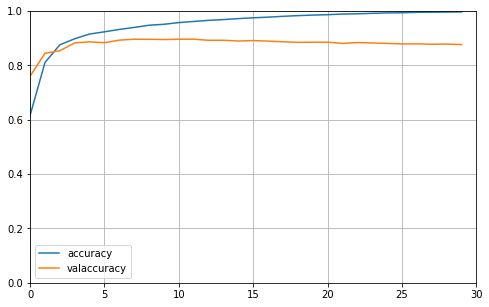

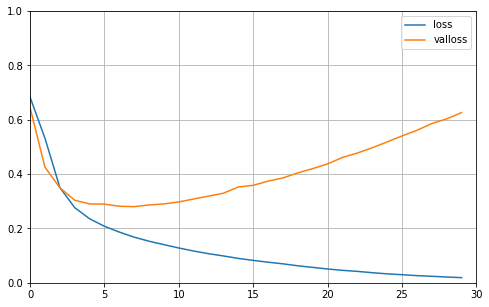

In [27]:
# 绘制学习曲线
def plot_learning_curves(history,label,epochs,min_value,max_value):
    data={}
    data[label]=history.history[label]
    data['val'+label]=history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8,5))
    plt.grid(True)
    plt.axis([0,epochs,min_value,max_value])
    plt.show()

plot_learning_curves(history,'accuracy',30,0,1)
plot_learning_curves(history,'loss',30,0,1)

loss发生了过拟合

In [29]:
model.evaluate(
    test_data,test_labels,
    batch_size=batch_size,
    verbose=1
)

196/196 [==============================] - 1s 3ms/step - loss: 0.6742 - accuracy: 0.8592


[0.6741971373558044, 0.8592000007629395]